Goal: Create a deep learning model that is able to take an image of a fish eye and predict its freshness based on three classes - Highly fresh, fresh, not fresh. 

Input: Fisheye image
Output: Freshness classification 
Constraints: Small dataset, different species
Performance Metrics: Accuracy, F1, Confusion matrix

LLM USAGE: 20 prompts x 2.32 g of CO2 = 46.4 g CO2

- How to process images with Pytorch
- How can i iterate through folders and images to extract label information using split()?
- What are some libraries i may need to perform this preprocessing 
- These are the layers Pytorch states to use with image classification, how could i expand it to make it more robust/ collect more features?
- How can i export the model weights, and training history for later use?
- How can i move my model on to a cloud gpu? 
- How can i plot the confusion matrix as a figure?
- How can i plot my probabilities to show confidence? Initally was returning confidewnce as string and not array. 
- How can i calulcate the mean and std of my training set for normalizaiton? 



Other Sources Include:
- https://docs.pytorch.org/docs/stable/index.html
- https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Much of the below model development has been based on previous assignments. 

In [5]:
import sys
!pip install --upgrade pip
!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install matplotlib pandas scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu121


In [16]:
%matplotlib inline

import matplotlib
print("Backend:", matplotlib.get_backend())

import matplotlib.pyplot as plt


Backend: inline


In [17]:
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")

import matplotlib.pyplot as plt
print("Backend (after use):", matplotlib.get_backend())


Backend (after use): module://matplotlib_inline.backend_inline


In [35]:
#imports

import os, glob, random
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, recall_score, precision_score

import torch.nn.functional as F



from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torchvision.models as models



#Global
IMG_SIZE = 224
RANDOM_SEED = 42
BATCH = 32
NUM_CLASSES = 3
CLASS_NAMES = ["Highly Fresh", "Fresh", "Not Fresh"]
DATA_ROOT = Path("data/mendeley")
ARTIFACT_DIR = Path("artifacts")
split_dir = ARTIFACT_DIR / "splits"
py_mean = torch.tensor([0.485, 0.456, 0.406])
py_std  = torch.tensor([0.229, 0.224, 0.225])

Helper Functions

In [3]:
#Helper function to switch between GPU and CPU
def model_device(model):
    return next(model.parameters()).device

#Clone best state
def clone_state(sd):
        cloned = {}
        for i, j in sd.items():
            cloned[i] = j.detach().clone()

        return cloned

#Train one epoch, for a given model and loader (iterates once through all files)
def train_one_epoch(model, loader, criterion, optimizer):

    model.train()
    dev = model_device(model)
    total_loss, correct, n = 0.0, 0, 0

    for b, (xb, yb) in enumerate(loader):

        xb, yb = xb.to(dev), yb.to(dev)

        optimizer.zero_grad()
        score = model(xb)
        loss = criterion(score, yb)
        loss.backward()

        #Training loop
        optimizer.step()

        total_loss += loss.item() *xb.size(0)
        correct += (score.argmax(1) == yb).sum().item()
        n += xb.size(0)

        if b % 50 == 0:
            print(f"  batch {b:04d}  loss {loss.item():.4f}", end="\r")
    print()
    return total_loss / max(1, n), correct / max(1, n)

@torch.no_grad()
#Calculate loss of one epoch
def eval_one_epoch(model, loader, criterion):
    model.eval()
    dev = model_device(model)
    total_loss, correct, n = 0.0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(dev), yb.to(dev)
        logits = model(xb)
        loss = criterion(logits, yb)

        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        n += xb.size(0)

    return total_loss / max(1, n), correct / max(1, n)    


#Randomly select items from the test set to test a model against
def show_random_predictions(model, dataset, n=5, class_names = CLASS_NAMES):
    model.eval()
    rows = []
    device = next(model.parameters()).device
    
   
    idxs = random.sample(range(len(dataset)),n)
    
    for i, idx in enumerate(idxs, start = 1):
        x, y_true = dataset[idx]
        x_in = x.unsqueeze(0).to(device)
        
        with torch.no_grad():
            score = model(x_in)
            probs = F.softmax(score, dim = 1).cpu().squeeze(0)
            
        pred_idx = int(torch.argmax(probs).item())
        true_label = class_names[y_true] if class_names else str(y_true)
        pred_label = class_names[pred_idx] if class_names else str(pred_idx)
        probs_str = ", ".join(f"{p:.3f}" for p in probs.tolist())
        rows.append({
            "Prediction": pred_label,
            "True Label": true_label,
            "Probability": probs_str,
        })
    
    return pd.DataFrame(rows)


#Run Test Set and collect metrics 
def make_predictions(model, dataset, n=5, class_names = CLASS_NAMES):
    model.eval()
    rows = []
    device = next(model.parameters()).device
   
   
    label = []
    pred = []
    iterations = 0

    for i in range(n):
        
        x, y_true = dataset[i]
        x_in = x.unsqueeze(0).to(device)
        
        with torch.no_grad():
            score = model(x_in)
            probs = F.softmax(score, dim = 1).cpu().squeeze(0) #Probability
            
        pred_idx = int(torch.argmax(probs).item())
        true_label = class_names[y_true] if class_names else str(y_true)
        pred_label = class_names[pred_idx] if class_names else str(pred_idx)
     
        rows.append({
            "Prediction": pred_label,
            "TrueLabel": true_label,
            "Iteration": i + 1,
            "Probs": probs.tolist()
        })

        label.append(true_label)
        pred.append(pred_label)

    return pd.DataFrame(rows), label, pred #Return datafram, true labels as array, and predicted labels as array

#Calculate accuracy, recall, and precision 
def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, average = "macro")
    rec = recall_score(y_true,y_pred, average = "macro")

    return acc, pre, rec 



# ---------- Core Grad-CAM class ----------

class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: trained CNN (e.g., FreshnessClass_withDropout or ResNet18)
        target_layer: conv layer module to inspect
                      e.g., model.conv2  (CNN)
                            model.layer4[-1] (ResNet18)
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            # feature maps from target layer
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            # gradients w.r.t. those feature maps
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)

        # Support for both new and old PyTorch hook APIs
        try:
            self.target_layer.register_full_backward_hook(backward_hook)
        except AttributeError:
            self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        """
        x: [1, 3, H, W]
        class_idx: if None, use predicted class
        returns: (cam, logits)
            cam: [1,1,h,w] heatmap in [0,1]
        """
        self.model.eval()
        self.model.zero_grad()

        logits = self.model(x)  # [1, num_classes]
        if class_idx is None:
            class_idx = int(logits.argmax(dim=1).item())

        one_hot = torch.zeros_like(logits)
        one_hot[0, class_idx] = 1.0

        logits.backward(gradient=one_hot, retain_graph=True)

        grads = self.gradients          # [1, C, h, w]
        acts  = self.activations        # [1, C, h, w]

        # global average pool gradients -> weights
        weights = grads.mean(dim=(2, 3), keepdim=True)  # [1, C, 1, 1]

        # weighted combination of feature maps
        cam = (weights * acts).sum(dim=1, keepdim=True)  # [1, 1, h, w]
        cam = torch.relu(cam)

        # normalize to [0,1]
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam, logits


# ---------- Helper: figure out default target layer ----------

def get_default_target_layer(model):
    """
    Heuristic to choose a good conv layer depending on model type.
    - ResNet18: last block of layer4
    - Freshness CNN: conv2
    """
    # ResNet-style
    if hasattr(model, "layer4"):
        layer4 = model.layer4
        if isinstance(layer4, torch.nn.Sequential) and len(layer4) > 0:
            return layer4[-1]

    # Your custom CNN
    if hasattr(model, "conv2"):
        return model.conv2

    raise ValueError("Could not infer target layer for Grad-CAM. "
                     "Please pass target_layer explicitly.")


# ---------- Helper: denormalize for display ----------

def denormalize(img_tensor, mean, std):
    """
    Undo normalization to get [0,1] RGB for plotting.
    img_tensor: [3,H,W]
    mean, std: tensors or lists of length 3
    """
    if isinstance(mean, list):
        mean_t = torch.tensor(mean).view(3, 1, 1)
        std_t  = torch.tensor(std).view(3, 1, 1)
    else:
        mean_t = mean.view(3, 1, 1)
        std_t  = std.view(3, 1, 1)

    img = img_tensor.detach().cpu() * std_t + mean_t
    img = img.clamp(0, 1)
    return img.permute(1, 2, 0).numpy()   # [H,W,3]


# ---------- Main reusable function: one sample ----------

def show_gradcam_sample(model, dataset, index=0, class_names=CLASS_NAMES, mean = py_mean, std= py_std, target_layer=None):
    """
    Visualize Grad-CAM for a single sample from a dataset.

    Works for:
      - CNN:  FreshnessClass_withDropout  (uses model.conv2 by default)
      - ResNet: build_resnet_model(...)   (uses model.layer4[-1] by default)

    Args:
        model: trained model with loaded weights
        dataset: e.g., test_ds
        index: which sample from dataset to visualize
        class_names: list of string labels
        mean, std: normalization stats (same as used in transforms)
        target_layer: optional; if None, auto-detects a good layer
    """
    dev = model_device(model) if "model_device" in globals() else next(model.parameters()).device

    # Get one example
    x, y_true = dataset[index]          # x: [3,H,W]
    x_in = x.unsqueeze(0).to(dev)       # [1,3,H,W]

    # Pick target layer if not given
    if target_layer is None:
        target_layer = get_default_target_layer(model)

    # Build Grad-CAM object & run
    gradcam = GradCAM(model, target_layer=target_layer)
    cam, logits = gradcam(x_in)

    probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
    pred_idx = int(probs.argmax())
    pred_prob = probs[pred_idx]

    # Resize CAM to image size
    cam_small = cam[0, 0].cpu()    # [h,w]
    H, W = x.shape[1], x.shape[2]
    cam_resized = TF.resize(cam_small.unsqueeze(0), size=[H, W])[0].numpy()

    # Denormalize original image
    img_np = denormalize(x, mean=mean.tolist() if hasattr(mean, "tolist") else mean,
                         std=std.tolist() if hasattr(std, "tolist") else std)

    plt.figure(figsize=(10, 4))

    # Original
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Original\nTrue: {class_names[y_true]}")

    # Heatmap alone
    plt.subplot(1, 3, 2)
    plt.imshow(cam_resized, cmap="jet")
    plt.axis("off")
    plt.title("Grad-CAM heatmap")

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(img_np)
    plt.imshow(cam_resized, cmap="jet", alpha=0.4)
    plt.axis("off")
    plt.title(f"Overlay\nPred: {class_names[pred_idx]} ({pred_prob:.2f})")

    plt.tight_layout()
    plt.show()


# ---------- Convenience: multiple indices in one go ----------


def show_gradcam_grid(model, dataset, indices, class_names=CLASS_NAMES, mean= py_mean, std=py_std, target_layer=None):
    """
    Show Grad-CAM for several samples, one after another.
    """
    for idx in indices:
        print(f"=== Sample index {idx} ===")
        show_gradcam_sample(
            model,
            dataset,
            index=idx,
            class_names=class_names,
            mean=mean,
            std=std,
            target_layer=target_layer,
        )

def get_one_index_per_class(dataset, class_names=CLASS_NAMES):
    """
    Scan dataset and return one index for each class in class_names.
    Assumes dataset[i] -> (image, label_idx) where label_idx matches class_names.
    """
    indices = {name: None for name in class_names}

    for idx in range(len(dataset)):
        _, y = dataset[idx]               # y is an int like 0,1,2
        label_name = class_names[y]

        if indices[label_name] is None:
            indices[label_name] = idx

        # stop early once we have one of each
        if all(v is not None for v in indices.values()):
            break

    return indices



In [4]:
import torch
print("torch:", torch.__version__)
print("torch cuda:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())

!nvidia-smi


torch: 2.5.1+cu121
torch cuda: 12.1
CUDA available: True
Mon Dec  1 19:36:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P8             12W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |               

Load data, build labels

In [5]:
#Load Data
#Extract folder name and split to identify labels
def build_labels(row_path: str):

    parts = row_path.split(" - ") #Path Name follows: Species - freshness\IMG_xxx
    species_raw, freshness_raw = parts #Split folder name to aquire species and freshness
    species = species_raw.strip().lower()
    freshness = freshness_raw.strip().lower()

    if freshness == "highly fresh": #Map freshness to values 0, 1, 2
        label,label_name = 0, "Highly Fresh"
    elif freshness == "fresh":
        label,label_name = 1, "Fresh"
    elif freshness == "not fresh":
        label,label_name = 2, "Not Fresh"

    return species, label, label_name

#Provide each image with a label
def build_image_labels(root: Path) -> pd.DataFrame: #Create the dataframe to hold our labels and info
    rows = []
    for image_path in root.rglob("*"):

        if not image_path.is_file(): #Ensure it is an image of correct type
            continue
        if image_path.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
            continue

        folder_name = image_path.parent.name
        species, label, label_name = build_labels(folder_name) #Build labels for each folder

        #Populate label dict
        rows.append({
            "path": str(image_path),
            "species": species,
            "label": label,
            "label_name": label_name,
        })

    return pd.DataFrame(rows)
   
#Store labels as dataframe
label_df = build_image_labels(DATA_ROOT) #Create DF using all data from mendeley set
display(label_df)




,path,species,label,label_name
0,data/mendeley/Chanos Chanos - Fresh/IMG_201911...,chanos chanos,1,Fresh
1,data/mendeley/Chanos Chanos - Fresh/IMG_201910...,chanos chanos,1,Fresh
2,data/mendeley/Chanos Chanos - Fresh/IMG_201910...,chanos chanos,1,Fresh
3,data/mendeley/Chanos Chanos - Fresh/IMG_201911...,chanos chanos,1,Fresh
4,data/mendeley/Chanos Chanos - Fresh/IMG_201911...,chanos chanos,1,Fresh
...,...,...,...,...
4385,data/mendeley/Oreochromis Mossambicus - Not Fr...,oreochromis mossambicus,2,Not Fresh
4386,data/mendeley/Oreochromis Mossambicus - Not Fr...,oreochromis mossambicus,2,Not Fresh
4387,data/mendeley/Oreochromis Mossambicus - Not Fr...,oreochromis mossambicus,2,Not Fresh
4388,data/mendeley/Oreochromis Mossambicus - Not Fr...,oreochromis mossambicus,2,Not Fresh


Analyze distribution to inspect for needed augmentations, data preprocessing, etc

Shape: (4390, 4)

Missing values per column:
path          0
species       0
label         0
label_name    0
dtype: int64

Label counts:
label_name
Highly Fresh    1764
Fresh           1320
Not Fresh       1306
Name: count, dtype: int64


label_name,Fresh,Highly Fresh,Not Fresh
label,,,
0,0,1764,0
1,1320,0,0
2,0,0,1306


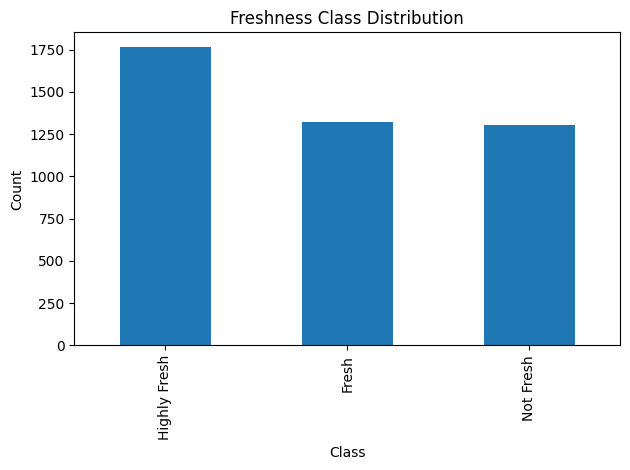

label_name,Fresh,Highly Fresh,Not Fresh
species,,,
chanos chanos,162,168,170
eleutheronema tetradactylum,80,80,80
johnius trachycephalus,80,80,80
nibea albiflora,125,173,121
oreochromis mossambicus,174,289,162
oreochromis niloticus,231,328,246
rastrelliger faughni,216,336,217
upeneus moluccensis,252,310,230


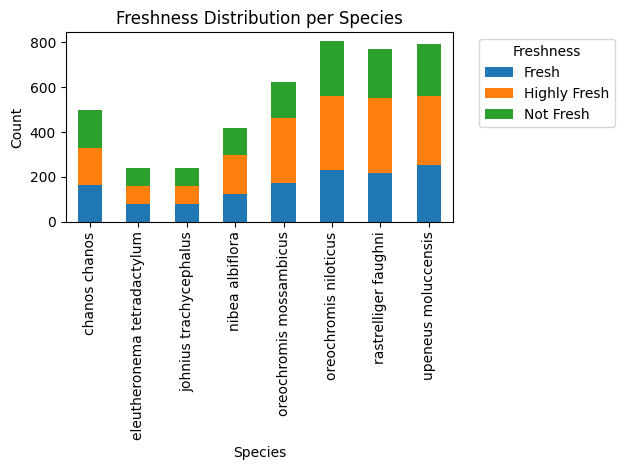

In [6]:
#Check what kinds of augmentation is needed
print("Shape:", label_df.shape)

#Check for NA - missing values
print("\nMissing values per column:")
print(label_df.isna().sum())

print("\nLabel counts:")
print(label_df["label_name"].value_counts())

#Check for class distribution 
tab = pd.crosstab(label_df["label"], label_df["label_name"])
display(tab)
ax = label_df["label_name"].value_counts().plot(kind="bar")
ax.set_title("Freshness Class Distribution")
ax.set_xlabel("Class"); ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig("images/Freshness Class Distribution.png")
plt.show()

#Freshness vs Species distribution 
ct = pd.crosstab(label_df["species"], label_df["label_name"])
display(ct)

ct.plot(kind = "bar", stacked = True)
plt.title("Freshness Distribution per Species")
plt.xlabel("Species")
plt.ylabel("Count")
plt.legend(title="Freshness", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("images/Freshness Distribution per Species.png")
plt.show()


Conclusions:

From Class Distribution:

Classes are relatively balances so heavy class balancing is not needed.

Freshness Vs Species:

Look reasonable spread, but not identical distrubution. Need to amplify smaller deatils of image to ensure lower appearing species are not underrepresented. 

Likely image augmentations: 
Image Size 
Random Image rotation
Random Image flips 


Train/Test Split

(3073, 4) (658, 4) (659, 4)
label
0    0.401887
1    0.300683
2    0.297429
Name: proportion, dtype: float64


label_name,Fresh,Highly Fresh,Not Fresh
species,,,
chanos chanos,111,121,120
eleutheronema tetradactylum,64,59,60
johnius trachycephalus,51,61,54
nibea albiflora,91,128,77
oreochromis mossambicus,125,203,117
oreochromis niloticus,164,227,175
rastrelliger faughni,143,232,154
upeneus moluccensis,175,204,157


label_name,Fresh,Highly Fresh,Not Fresh
species,,,
chanos chanos,27,22,24
eleutheronema tetradactylum,6,12,15
johnius trachycephalus,15,12,14
nibea albiflora,20,19,18
oreochromis mossambicus,22,46,21
oreochromis niloticus,42,59,32
rastrelliger faughni,26,46,31
upeneus moluccensis,40,48,41


label_name,Fresh,Highly Fresh,Not Fresh
species,,,
chanos chanos,24,25,26
eleutheronema tetradactylum,10,9,5
johnius trachycephalus,14,7,12
nibea albiflora,14,26,26
oreochromis mossambicus,27,40,24
oreochromis niloticus,25,42,39
rastrelliger faughni,47,58,32
upeneus moluccensis,37,58,32


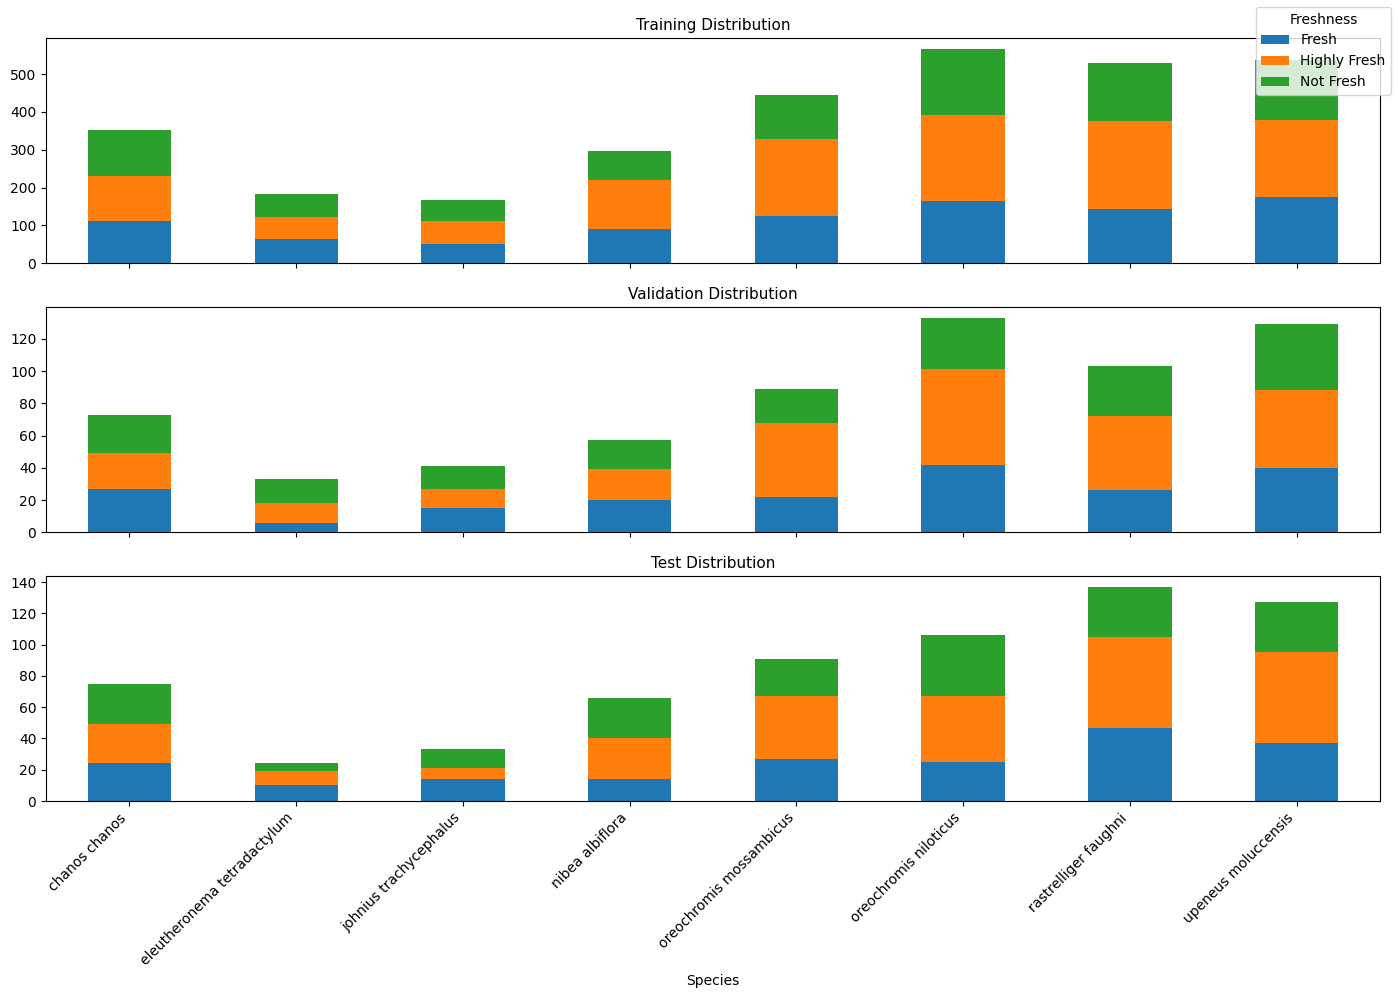

In [ ]:
#Train Split Data 70/15/15

train_df, temp_df = train_test_split(label_df, test_size = 0.3, stratify = label_df["label"], random_state = RANDOM_SEED) #Create 70/30 split

#Spllit 30 into 15/15
val_df, test_df = train_test_split(temp_df, test_size = 0.5, stratify = temp_df["label"], random_state = RANDOM_SEED)


print(train_df.shape, val_df.shape, test_df.shape)
print(train_df["label"].value_counts(normalize=True))



split_dir.mkdir(parents=True, exist_ok=True)

train_df.to_csv(split_dir / "train_split.csv", index=False)
val_df.to_csv(split_dir / "val_split.csv", index=False)
test_df.to_csv(split_dir / "test_split.csv", index=False)

#Check Split Class distribution
training_tab = pd.crosstab(train_df["species"], train_df["label_name"])
val_tab = pd.crosstab(val_df["species"], val_df["label_name"])
test_tab = pd.crosstab(test_df["species"], test_df["label_name"])
display(training_tab)
display(val_tab)
display(test_tab)


fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

tabs = [training_tab, val_tab, test_tab]
titles = ["Training Distribution", "Validation Distribution", "Test Distribution"]

for ax, tab, title in zip(axes, tabs, titles):
    tab.plot(kind="bar", stacked=True, ax=ax, legend=False)  # no legend per subplot
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("")  # we'll label x only once at bottom
    ax.tick_params(axis='x', labelrotation=0)  # temp; will fix on bottom

# put species labels only on bottom subplot, rotated nicely
axes[-1].set_xlabel("Species")
for label in axes[-1].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

# single shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", title="Freshness")

plt.tight_layout()
plt.savefig("images/Training Distribution per split.png")
plt.show()



Dataset Class:
init, len, getitem

In [10]:
#Dataset class that returns the len and returns the transformed input, and a tesnor output
class FishFreshnessDS(Dataset):
    def __init__(self, frame, transform):
        
        self.df = frame.reset_index(drop = True) #Renumbering 
        self.transform = transform
        self.paths = self.df["path"].tolist()
        self.labels = self.df["label"].astype(int).tolist()

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, i):

        img = Image.open(self.paths[i]).convert("RGB")
        x = self.transform(img) if self.transform else img
        y = torch.tensor(self.labels[i], dtype = torch.long)

        return x, y

Perform Image Transformations


In [18]:
#Calculate Mean and standard deviation for data

train_df = pd.read_csv(split_dir / "train_split.csv")
val_df   = pd.read_csv(split_dir / "val_split.csv")
test_df  = pd.read_csv(split_dir / "test_split.csv")

for df in (train_df, val_df, test_df):
    df["path"] = df["path"].str.replace("\\", "/", regex=False)

probe_tf = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),          
])

probe_ds = FishFreshnessDS(train_df, probe_tf)
probe_loader = DataLoader(probe_ds, batch_size=64, shuffle=False, num_workers=0)

n_pixels = 0
sum_c    = torch.zeros(3)
sumsq_c  = torch.zeros(3)

for xb, _ in probe_loader:          
    B, C, H, W = xb.shape
    n = B*H*W
    n_pixels += n
    sum_c   += xb.sum(dim=[0,2,3])
    sumsq_c += (xb**2).sum(dim=[0,2,3])

mean = sum_c / n_pixels
var  = (sumsq_c / n_pixels) - mean**2
std  = var.clamp_min(1e-12).sqrt()

print("train mean:", mean.tolist())
print("train std :", std.tolist())

#Transformations for training dataset, and validation dataset 
IMG_SIZE = 224
train_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=mean.tolist(), std=std.tolist()),   # <- use your stats
])

val_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=mean.tolist(), std=std.tolist()),
])

#Create training, validation, and test datasets 



train_ds = FishFreshnessDS(train_df, train_transforms)
val_ds = FishFreshnessDS(val_df, val_transforms) #Apply validation transforms to validaiton and test set
test_ds = FishFreshnessDS(test_df, val_transforms)




train mean: [0.48181256651878357, 0.4465354084968567, 0.42846518754959106]
train std : [0.1994909793138504, 0.19912664592266083, 0.19779568910598755]


Dataloader

In [19]:
#Dataloaders
train_loader = DataLoader(train_ds, batch_size = BATCH, shuffle = True) #Mini batch with shuffling
val_loader = DataLoader(val_df, batch_size = BATCH, shuffle = False)
test_loader = DataLoader(test_ds, batch_size= BATCH, shuffle = False)

Define Base Freshness Neural network

In [20]:
#Base neural network class... no dropout or regularizaiton
class FreshnessClass(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutional layers
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6, 32, 5)

        #Fully connected layers
        self.fc1 = nn.Linear(32*5*5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, NUM_CLASSES)

        #Activations and pool 
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.adapt = nn.AdaptiveAvgPool2d((5,5))
        
    def forward(self, x):
        
        x = self.activation((self.conv1(x))) 
        x = self.pool(x)
        x = self.activation((self.conv2(x)))
        x = self.pool(x)
        x = self.adapt(x)
        x = torch.flatten(x,1)

        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))

        x = self.out(x)

        return x      

Run Inital Test:
Using SGD Batch 32

Conclusions of inital test with base class: 
validation loss is stuck at around 1.077 with little improvement to both validation and training accuracy
Will test optimizations to seek improvements

*Output and cell performing the training was removed to prevent "run all" issues

Updated Class with Dropout

In [21]:
#Updated Class includes dropout p = 0.3
class FreshnessClass_withDropout(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutional layers
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6, 32, 5)

        #Fully connected layers
        self.fc1 = nn.Linear(32*5*5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, NUM_CLASSES)

        #Activations and pool and others
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.adapt = nn.AdaptiveAvgPool2d((5,5))
        self.drop = nn.Dropout(p=0.3)
        
    def forward(self, x):
        
        x = self.activation((self.conv1(x)))
        x = self.pool(x)
        x = self.activation((self.conv2(x)))
        x = self.pool(x)
        x = self.adapt(x)
        x = torch.flatten(x,1)

        x = self.activation(self.fc1(x))
        x = self.drop(x)
        x = self.activation(self.fc2(x))
        x = self.drop(x)

        x = self.out(x)

        return x      

Run Next Test:
Use Dropout, SGD, L2 Regularization, optimizing schweduler
Switched from SGD optimizer to AdamW

In [ ]:
LEARNING_RATE = 5e-4
EPOCHS = 25
BATCH = 16
best_state, best_val = None, 0.0


#Load datasets 
train_loader = DataLoader(train_ds, batch_size = BATCH, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = BATCH, shuffle = False)
test_loader = DataLoader(train_ds, batch_size = BATCH, shuffle = False)

#Initalize the model 
model = FreshnessClass_withDropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay= 1e-4)
#Using optimizer scheduler 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

#Implementing Early stopping with a patience of 4
bad = 0
patience = 4

#Create a history log to track losses and accuracies over epochs
history = {
    "epoch":[],
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[],
}


#Iterate through epochs 
for epoch in range(1, EPOCHS + 1):
    
    #Train and evaluate each epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion)
    print(f"Epoch {epoch:02d} | train {train_loss:.4f}/{train_acc:.3f} | val {val_loss:.4f}/{val_acc:.3f}")

    #Append training history
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    
    #Update and save best model
    if val_acc > best_val:
        best_val = val_acc
        best_state = clone_state(model.state_dict())
        bad = 0
    else:
        #Early stopping
        bad += 1
        if(bad > patience):
            print(f"Early stopping - Iteration: {epoch}")
            break

#If we found a best state save it as a pytorch file (contains model weights for later usage)
if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(best_state, ARTIFACT_DIR / "best_model_state_dict.pt")


#Check models performance on test set 
test_loss, test_acc = eval_one_epoch(model, test_loader, criterion)
print(f"TEST | loss {test_loss:.4f}  acc {test_acc:.3f}")

#Save training history as a csv
history_df = pd.DataFrame(history)
history_df.to_csv(ARTIFACT_DIR / "training_history.csv", index = False)
print("Saved:", ARTIFACT_DIR / "training_history.csv")



  batch 0150  loss 1.2027
Epoch 01 | train 1.0859/0.402 | val 1.0836/0.401
  batch 0150  loss 1.0662
Epoch 02 | train 1.0759/0.418 | val 1.0443/0.453
  batch 0150  loss 1.0083
Epoch 03 | train 1.0483/0.453 | val 1.0204/0.495
  batch 0150  loss 0.9268
Epoch 04 | train 1.0155/0.494 | val 0.9758/0.547
  batch 0150  loss 0.8953
Epoch 05 | train 0.9655/0.547 | val 0.9262/0.541
  batch 0150  loss 0.9446
Epoch 06 | train 0.9249/0.567 | val 0.8992/0.585
  batch 0150  loss 0.8683
Epoch 07 | train 0.9074/0.575 | val 0.8734/0.584
  batch 0150  loss 0.9167
Epoch 08 | train 0.8916/0.583 | val 0.8730/0.608
  batch 0150  loss 0.7420
Epoch 09 | train 0.8630/0.604 | val 0.8687/0.578
  batch 0150  loss 0.8653
Epoch 10 | train 0.8645/0.594 | val 0.8528/0.609
  batch 0150  loss 0.8854
Epoch 11 | train 0.8496/0.602 | val 0.8773/0.593
  batch 0150  loss 0.7758
Epoch 12 | train 0.8383/0.612 | val 0.8453/0.611
  batch 0150  loss 0.7486
Epoch 13 | train 0.8414/0.618 | val 0.8444/0.603
  batch 0150  loss 0.7498

Function to test on n samples from test set

In [22]:

#Random Test to just visualize data 

model = FreshnessClass_withDropout()
model.eval()
#Load best state weights from saved pytorch file
state_dict = torch.load(ARTIFACT_DIR / "best_model_state_dict.pt", map_location="cpu")
model.load_state_dict(state_dict)        
show_random_predictions(model, test_ds, n = 15)



/var/tmp/ipykernel_12349/103943409.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ARTIFACT_DIR / "best_model_state_dict.pt", map_location="cpu")

,Prediction,True Label,Probability
0,Fresh,Fresh,"0.168, 0.536, 0.296"
1,Not Fresh,Not Fresh,"0.000, 0.000, 1.000"
2,Highly Fresh,Not Fresh,"0.571, 0.234, 0.194"
3,Highly Fresh,Fresh,"0.657, 0.236, 0.107"
4,Fresh,Not Fresh,"0.331, 0.402, 0.267"
5,Fresh,Not Fresh,"0.144, 0.576, 0.281"
6,Highly Fresh,Not Fresh,"0.517, 0.289, 0.193"
7,Highly Fresh,Highly Fresh,"0.509, 0.292, 0.199"
8,Highly Fresh,Fresh,"0.438, 0.339, 0.222"
9,Fresh,Fresh,"0.389, 0.396, 0.215"


EVALUATION USING TRAINED FreshnessClass_withDropout MODEL 


Plot Validation and Training Loss Curves


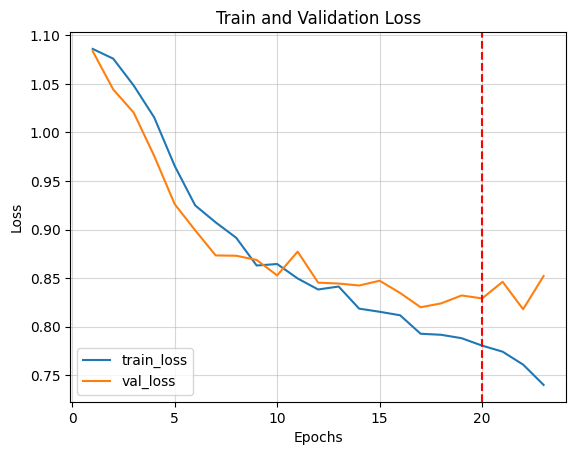

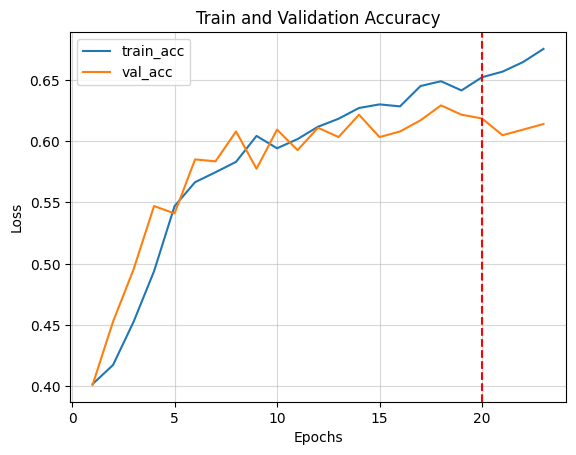

In [23]:
#Plot validation and training loss curves for best model

#Load training history csv as df
training_history = pd.read_csv(ARTIFACT_DIR /"training_history.csv")
epochs = len(training_history["epoch"])

#Plot loss curves
training_history.plot(x = 'epoch', y=['train_loss', 'val_loss'] )
plt.title("Train and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.axvline(x=20, color='red', linestyle='--', label=f'Early Stopping at {epochs} iterations')
plt.grid(True, alpha = 0.5)
plt.savefig("images/Train_Val_loss.png")
plt.show()

training_history.plot(x = 'epoch', y=['train_acc', 'val_acc'] )
plt.title("Train and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.axvline(x=20, color='red', linestyle='--', label=f'Early Stopping at {epochs} iterations')
plt.grid(True, alpha = 0.5)
plt.savefig("images/Train_Val_Acc.png")
plt.show()

FreshnessClass_withDropout Performance Metrics


In [24]:
#Make predictions on test set once
model = FreshnessClass_withDropout()
model.eval()
#Load best state weights from saved pytorch file
state_dict = torch.load(ARTIFACT_DIR / "best_model_state_dict.pt", map_location="cpu")
model.load_state_dict(state_dict) 
performance_df, true_label, y_pred = make_predictions(model, test_ds, n =len(test_ds))
out_df = performance_df.copy()
out_df["true_label"] = true_label
out_df["pred_label"] = y_pred

# Save to CSV (in the current working directory)
out_df.to_csv(ARTIFACT_DIR / "test_predictions.csv", index=False)
print("Saved to test_predictions.csv")



/var/tmp/ipykernel_12349/471596716.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ARTIFACT_DIR / "best_model_state_dict.pt", map_location="cpu")

Saved to test_predictions.csv


Class Count: Counter({'Highly Fresh': 265, 'Fresh': 198, 'Not Fresh': 196})
Majority Class: Highly Fresh
Majority Baseline: 0.40212443095599393
Accuracy: 0.672, Precision: 0.692, Recall: 0.648
Improvement over majority baseline (accuracy): 0.2701


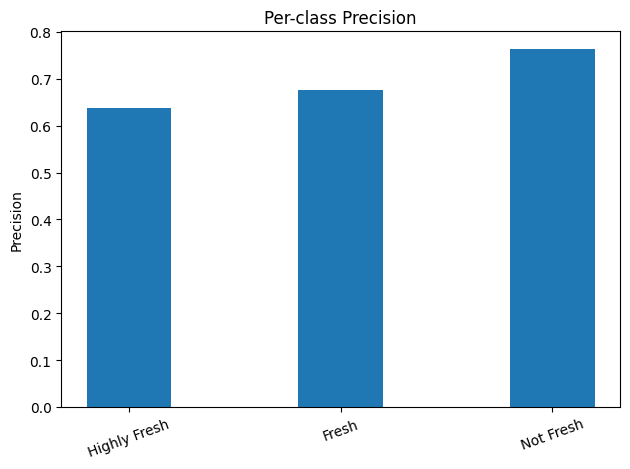

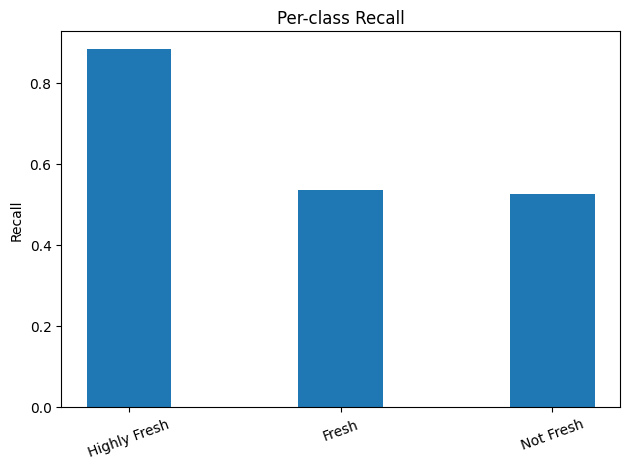

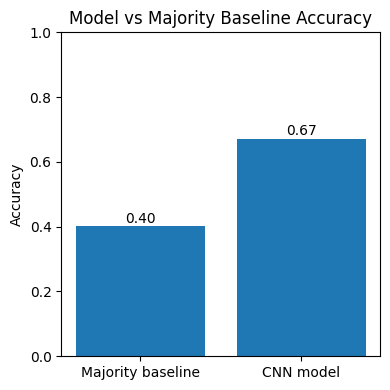

Confusion Matrix:


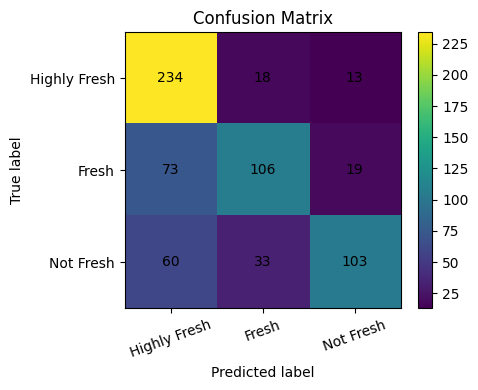

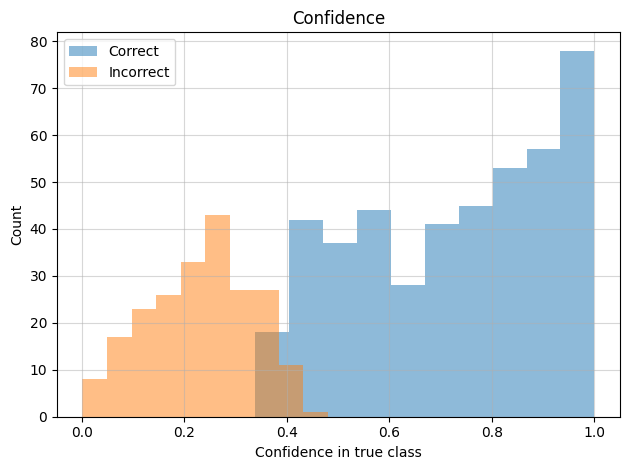

{'Highly Fresh': 0, 'Fresh': 5, 'Not Fresh': 4}


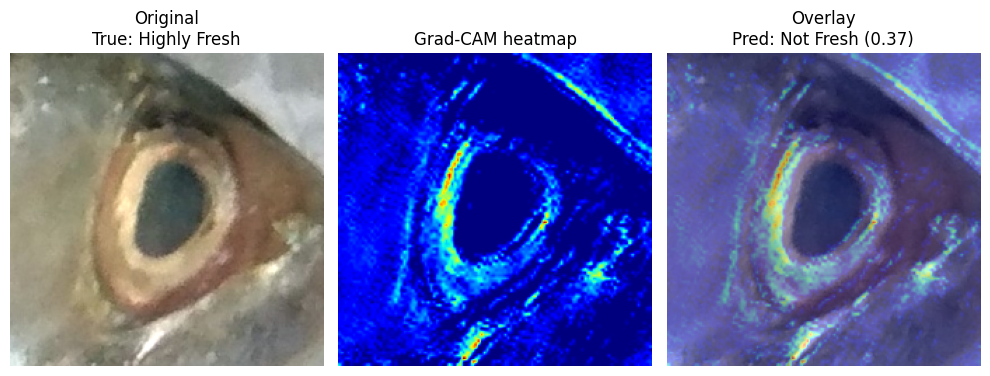

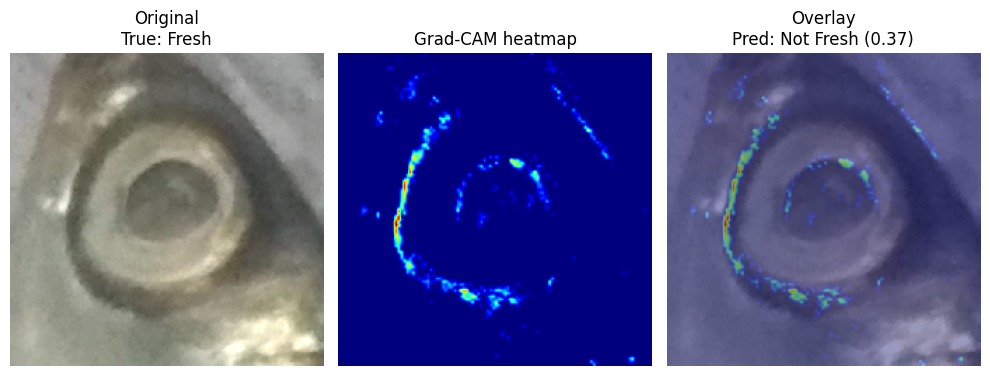

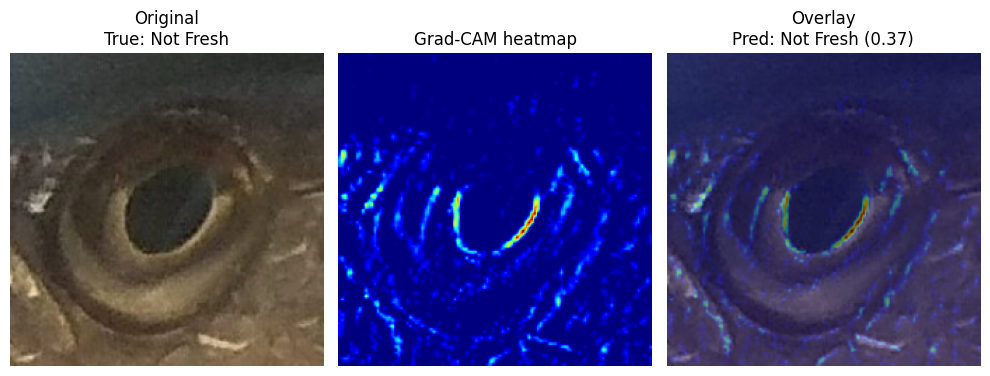

In [25]:
#Calculate performance metrics and confusion matrix on Test Set
import ast
#Calculate Majority Baseline
from collections import Counter
performance_df = pd.read_csv(ARTIFACT_DIR / "test_predictions.csv")

performance_df["Probs"] = performance_df["Probs"].apply(ast.literal_eval)

y_prob = performance_df["Probs"].tolist()

conf_correct = []
conf_incorrect = []

# Get labels
true_label = performance_df["true_label"].tolist()
y_pred     = performance_df["pred_label"].tolist()
counts = Counter(true_label)
print("Class Count:", counts)

n = len(true_label)
majority_class, majority_count = counts.most_common(1)[0]
majority_baseline_accuracy = majority_count/n

print(f"Majority Class: {majority_class}")
print(f"Majority Baseline: {majority_baseline_accuracy}")

#--------------------------------------------------------------------------------------------------#
#Accuracy, preciison, recall
#Calculate overall accuracy, precision, recall
acc, pre, rec = get_metrics(true_label, y_pred)
print(f"Accuracy: {acc:.3f}, Precision: {pre:.3f}, Recall: {rec:.3f}")
print(f"Improvement over majority baseline (accuracy): {acc - majority_baseline_accuracy:.4f}")

#Plot per class recall and precision
pre_per_class = precision_score(true_label, y_pred, average=None, labels=CLASS_NAMES)
rec_per_class = recall_score(true_label, y_pred, average=None, labels=CLASS_NAMES)

x = range(len(CLASS_NAMES))

plt.figure()
plt.bar(x, pre_per_class, width=0.4)
plt.xticks(x, CLASS_NAMES, rotation=20)
plt.ylabel("Precision")
plt.title("Per-class Precision")
plt.tight_layout()
plt.savefig("images/Per_Class Precision.png")

plt.show()

plt.figure()
plt.bar(x, rec_per_class, width=0.4)
plt.xticks(x,CLASS_NAMES, rotation=20)
plt.ylabel("Recall")
plt.title("Per-class Recall")
plt.tight_layout()

plt.show()

#Plot majority baseline vs our model 
methods = ["Majority baseline", "CNN model"]
accuracies = [majority_baseline_accuracy, acc]

plt.figure(figsize=(4, 4))
plt.bar(methods, accuracies)
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Model vs Majority Baseline Accuracy")

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig("images/ModelvsBaseline.png")

plt.show()

#--------------------------------------------------------------------------------------------------#
#Confusion Matrix

#re-introduce Label_name -> mapping
class_map = {
    "Highly Fresh": 0,
    "Fresh": 1, 
    "Not Fresh": 2
}

true_mapped =[]
pred_mapped =[]

#Calculate performance metrics based on array of mapped label values
for label in true_label:
    true_mapped.append(class_map[label])
for label in y_pred:
    pred_mapped.append(class_map[label])


cm = confusion_matrix(true_mapped, pred_mapped)
print("Confusion Matrix:")

#Plot Confusion Matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES, rotation=20)
plt.yticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES)

# Annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.savefig("images/Confusion.png")
plt.show()

#------------------------------------------------------------------------------------------------------------#
#Confidence

#Extract confidence from performance df
conf_correct = []
conf_incorrect = []
y_prob = performance_df["Probs"]
for i in range(len(true_label)):
    true_idx = class_map[true_label[i]]
    p_true = y_prob[i][true_idx]
    if y_pred[i] == true_label[i]:
        conf_correct.append(p_true)
    else: 
        conf_incorrect.append(p_true)

#Plot condifence
plt.figure()
plt.hist(conf_correct, bins=10, alpha=0.5, label="Correct")
plt.hist(conf_incorrect, bins=10, alpha=0.5, label="Incorrect")
plt.xlabel("Confidence in true class")
plt.ylabel("Count")
plt.title("Confidence")
plt.legend()
plt.tight_layout()
plt.grid(True, alpha=0.5)
plt.show()

model = FreshnessClass_withDropout()
model.eval()
indices = get_one_index_per_class(test_ds, CLASS_NAMES)
print(indices)
# Single example
show_gradcam_sample(model, test_ds, index=indices["Highly Fresh"])
show_gradcam_sample(model, test_ds, index=indices["Fresh"])
show_gradcam_sample(model, test_ds, index=indices["Not Fresh"])




Performance Metrics on Test set

Majority Class: 'Highly Fresh' - 265 samples
Majority Baseline: 0.402
Overall Accuracy: 0.672
Precision: 0.692
Recall: 0.648


Per Class Breakdown:

Highly Fresh:

    Recall: 234/265 = 88.3%
    Precision: 234/367 = 63.8%
    F1 = 0.74

    The model can catch Highly Fresh samples well

Fresh: 
    
    Recall: 106/196 = 52.6%
    Precision: 106/157 = 67.5%
    F1 = 0.59

Not Fresh: 

    Recall: 103/196 = 52.6%
    Precision: 103/135 = 76.3%
    F1: 0.62





Performance Metric Summary

Based on the charts and metrics above we can see that the majority baseline is 40.2%, which we beat with an accuracy of 67.2%. An increase of 27 percentage points. This tells us that the model is learning meaningful features and not choosing the majority class without reason. 

The "Highly Fresh" class has the highest recall and precision scores. Based on this and the confusion matrix we can identify that the model rarely misses true "Highly Fresh" samples. 

"Fresh" and "Not Fresh" classes are harder to classify with identical recalls. This indicates misclassifications between neighbouring classes. 

No class is being completely neglected ensuring our model is learning correctly.

Confidence Histogram shows that most correct predictions have higher confidence, probability -> 1. Whereas the opposite happens for incorrect predictions where they have lower confidence as expected. This tells us that the model's confidence is aligned with correctness This follows the behaviour we want, where the model is confident when right and less confident when its wrong. Alternatively, if the distribution showed it was confident when wrong, major classification issues would arise. 


TA FEEDBACK: 
- Generate more graphs for report: Plan to include per class metrics, confiedence graph (probabilityies)
- Accuracy is higher than baseline but can aim for better performance
- Consider expanding network size, number of nodes and layers to pick up more features
- Consider implementing "RESNET EFFICIENCY"

<h1>POST PROGRESS UPDATES:<h1>

<h3>Build ResNet:</h3>

In [26]:

def build_resnet_model(num_classes = NUM_CLASSES, freeze_until_layer4 = True, p = 0.5):
    
    try:
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights = weights)
    except AttributeError:
        
        model = models.resnet18(pretrained = True)
        
        if freeze_until_layer4:
            for name, param in model.named_parameters():
                if not (name.startswith("layer4") or name.startswith("fc")):
                    param.requires_grad = False
                    
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p),
        nn.Linear(in_features, num_classes)
    )
    return model
                

In [75]:
IMG_SIZE = 224
train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.ToTensor(),
    T.Normalize(py_mean.tolist(), py_std.tolist()),
])

val_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=mean.tolist(), std=std.tolist()),
])

#Create training, validation, and test datasets 
train_ds = FishFreshnessDS(train_df, train_transforms)
val_ds = FishFreshnessDS(val_df, val_transforms) #Apply validation transforms to validaiton and test set
test_ds = FishFreshnessDS(test_df, val_transforms)

Train ResNet

In [76]:
LEARNING_RATE = 1e-4
EPOCHS = 30
BATCH = 32
WEIGHT_DECAY = 5e-4
#Load datasets 
train_loader = DataLoader(train_ds, batch_size = BATCH, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = BATCH, shuffle = False)
test_loader = DataLoader(test_ds, batch_size = BATCH, shuffle = False)

#Initalize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_resnet_model(num_classes=NUM_CLASSES, freeze_until_layer4=True).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)

backbone_params = []
head_params = []

for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if name.startswith("layer4") or name.startswith("fc"):
        head_params.append(param)        # last block + classifier
    else:
        backbone_params.append(param)    # earlier layers (if any unfrozen)
        
#Using optimizer scheduler 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

#Implementing Early stopping with a patience of 5
best_val = float("inf")
no_improvement = 0
patience = 5

#Create a history log to track losses and accuracies over epochs
history = {
    "epoch":[],
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[],
}


#Iterate through epochs 
for epoch in range(1, EPOCHS + 1):
    
    #Train and evaluate each epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion)
    print(f"Epoch {epoch:02d} | train {train_loss:.4f}/{train_acc:.3f} | val {val_loss:.4f}/{val_acc:.3f}")

    #Append training history
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    
    scheduler.step(val_loss)
    
    #Update and save best model
    if val_loss < best_val:
        best_val = val_loss
        best_state = clone_state(model.state_dict())
        no_improvement = 0
        print("  -> new best val_loss, saving state")
    else:
        no_improvement += 1
        print(f"  no improvement in val_loss ({no_improvement}/{patience})")
        if no_improvement >= patience:
            print(f"Early stopping - Iteration: {epoch}")
            break

#If we found a best state save it as a pytorch file (contains model weights for later usage)
if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(best_state, ARTIFACT_DIR / "best_model_state_dict_resnet.pt")


#Check models performance on test set 
test_loss, test_acc = eval_one_epoch(model, test_loader, criterion)
print(f"TEST | loss {test_loss:.4f}  acc {test_acc:.3f}")

#Save training history as a csv
history_df = pd.DataFrame(history)
history_df.to_csv(ARTIFACT_DIR / "training_history_resnet.csv", index = False)
print("Saved:", ARTIFACT_DIR / "training_history_resnet.csv")

  batch 0050  loss 0.9561
Epoch 01 | train 0.9323/0.576 | val 0.8987/0.632
  -> new best val_loss, saving state
  batch 0050  loss 0.7442
Epoch 02 | train 0.7747/0.709 | val 0.7874/0.696
  -> new best val_loss, saving state
  batch 0050  loss 0.6370
Epoch 03 | train 0.7088/0.752 | val 0.9048/0.650
  no improvement in val_loss (1/5)
  batch 0050  loss 0.8056
Epoch 04 | train 0.6501/0.791 | val 0.7965/0.695
  no improvement in val_loss (2/5)
  batch 0050  loss 0.6035
Epoch 05 | train 0.6214/0.811 | val 0.8065/0.714
  no improvement in val_loss (3/5)
  batch 0050  loss 0.5533
Epoch 06 | train 0.5541/0.855 | val 0.8137/0.726
  no improvement in val_loss (4/5)
  batch 0050  loss 0.4967
Epoch 07 | train 0.5138/0.888 | val 0.7576/0.764
  -> new best val_loss, saving state
  batch 0050  loss 0.4388
Epoch 08 | train 0.5035/0.893 | val 0.7768/0.739
  no improvement in val_loss (1/5)
  batch 0050  loss 0.4605
Epoch 09 | train 0.4871/0.903 | val 0.8085/0.742
  no improvement in val_loss (2/5)
  ba

EAVLUATION USING ResNet18 MODEL

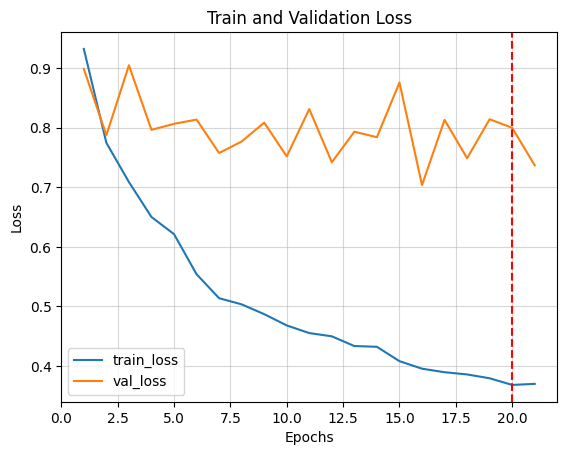

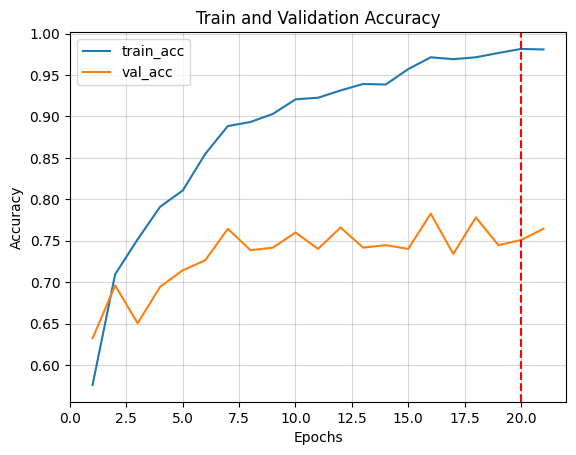

In [31]:
#Plot validation and training loss curves for best model

#Load training history csv as df
training_history = pd.read_csv(ARTIFACT_DIR /"training_history_resnet.csv")
epochs = len(training_history["epoch"])

#Plot loss curves
training_history.plot(x = 'epoch', y=['train_loss', 'val_loss'] )
plt.title("Train and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.axvline(x=20, color='red', linestyle='--', label=f'Early Stopping at {epochs} iterations')
plt.grid(True, alpha = 0.5)
plt.savefig("images/Train_Val_loss_resnet.png")
plt.show()

training_history.plot(x = 'epoch', y=['train_acc', 'val_acc'] )
plt.title("Train and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.axvline(x=20, color='red', linestyle='--', label=f'Early Stopping at {epochs} iterations')
plt.grid(True, alpha = 0.5)
plt.savefig("images/Train_Val_Acc_resnet.png")
plt.show()

In [78]:
#Make predictions on test set once

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_resnet_model(num_classes=NUM_CLASSES, freeze_until_layer4=True).to(device)
model.eval()
state_dict = torch.load(ARTIFACT_DIR / "best_model_state_dict_resnet.pt", map_location = torch.device('cpu'), weights_only = True)
model.load_state_dict(state_dict)        
performance_df, true_label, y_pred = make_predictions(model, test_ds, n =len(test_ds))
out_df = performance_df.copy()
out_df["true_label"] = true_label
out_df["pred_label"] = y_pred

# Save to CSV (in the current working directory)
out_df.to_csv(ARTIFACT_DIR / "resnet_test_predictions.csv", index=False)
print("Saved to resnet_test_predictions.csv")

Saved to resnet_test_predictions.csv


Class Count: Counter({'Highly Fresh': 265, 'Fresh': 198, 'Not Fresh': 196})
Majority Class: Highly Fresh
Majority Baseline: 0.40212443095599393
Accuracy: 0.780, Precision: 0.778, Recall: 0.773
Improvement over majority baseline (accuracy): 0.3778
Improvement over previous CNN model (accuracy): 0.1100


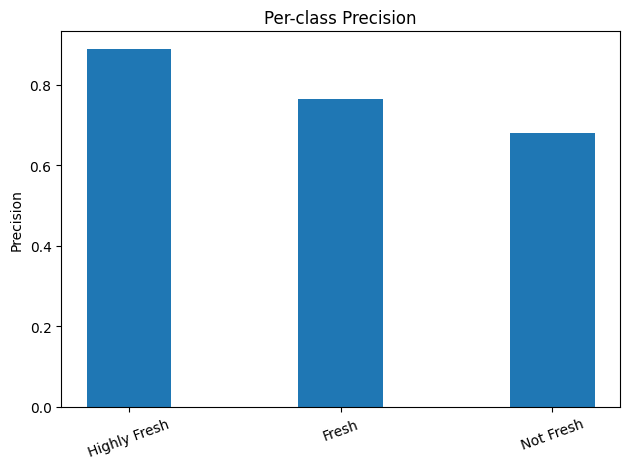

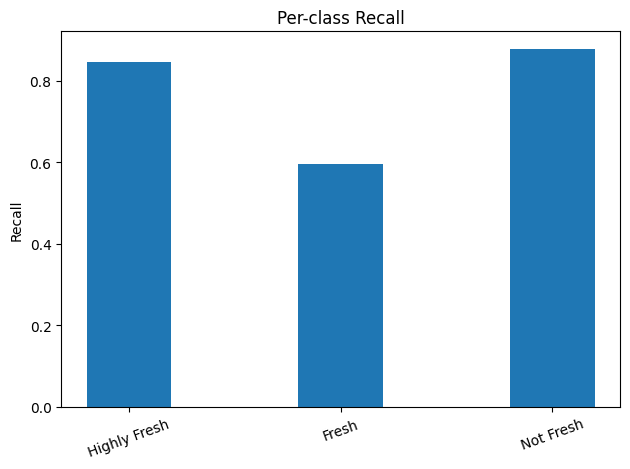

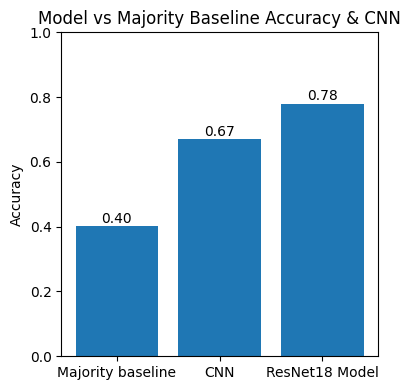

Confusion Matrix:


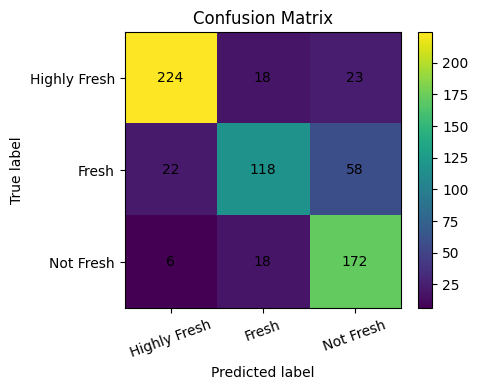

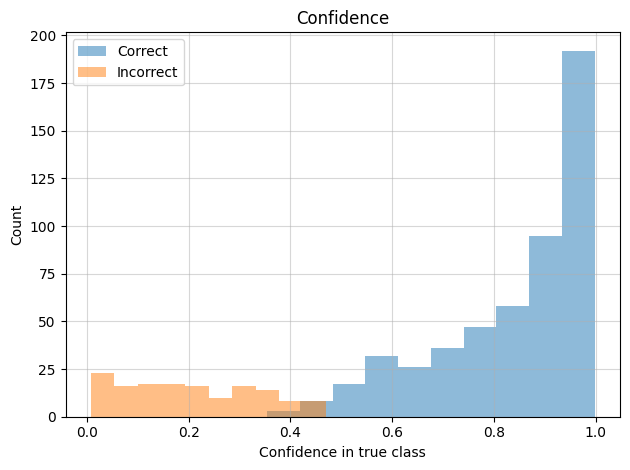

{'Highly Fresh': 0, 'Fresh': 5, 'Not Fresh': 4}


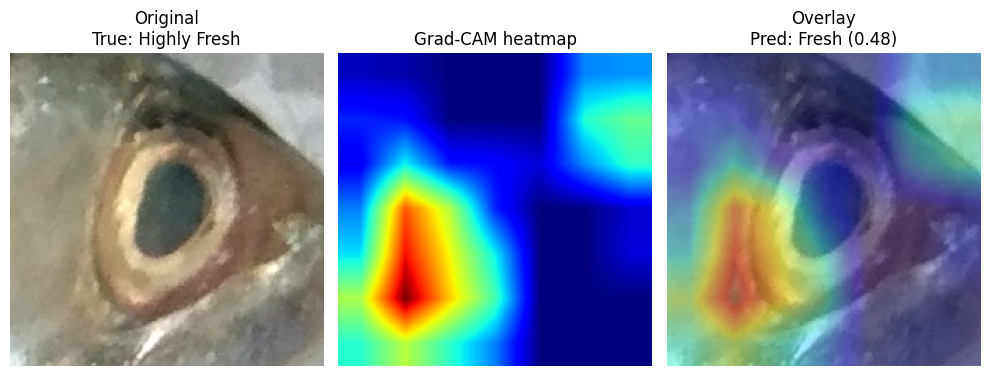

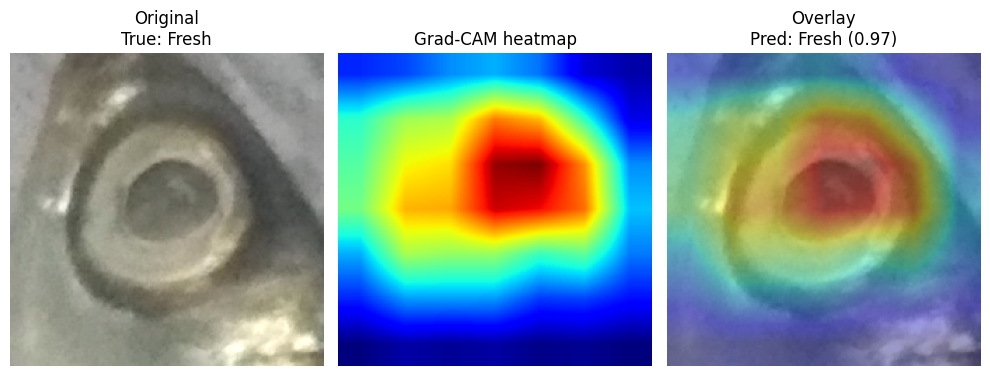

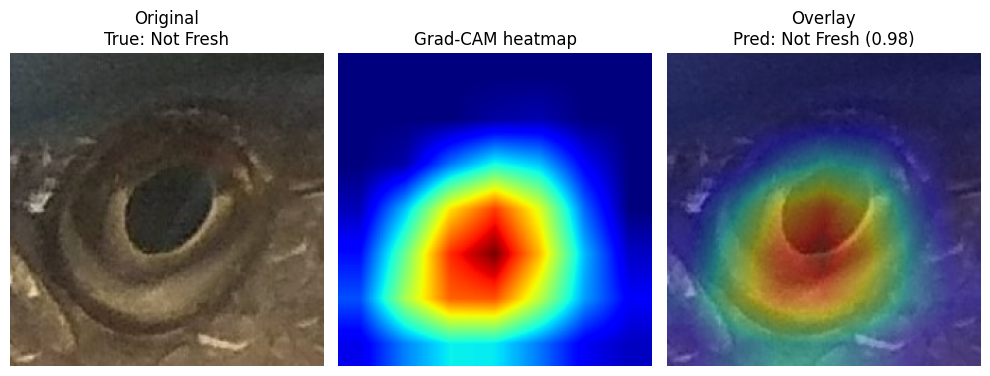

In [79]:
#Calculate performance metrics and confusion matrix on Test Set

#Calculate Majority Baseline
from collections import Counter

performance_df = pd.read_csv(ARTIFACT_DIR / "resnet_test_predictions.csv")

# Get labels
true_label = performance_df["true_label"].tolist()
y_pred     = performance_df["pred_label"].tolist()

counts = Counter(true_label)
print("Class Count:", counts)

n = len(true_label)
majority_class, majority_count = counts.most_common(1)[0]
majority_baseline_accuracy = majority_count/n

print(f"Majority Class: {majority_class}")
print(f"Majority Baseline: {majority_baseline_accuracy}")

import pandas as pd
import ast   # for turning stringified lists back into lists

# Load predictions from CSV instead of recomputing them


# If you stored the probability vector as a string, convert it back to a list
# (only needed if you use performance_df["Probs"] later, which you do)
if "Probs" in performance_df.columns and isinstance(performance_df["Probs"].iloc[0], str):
    performance_df["Probs"] = performance_df["Probs"].apply(ast.literal_eval)


cnn_acc = 0.67
#--------------------------------------------------------------------------------------------------#
#Accuracy, preciison, recall
#Calculate overall accuracy, precision, recall
acc, pre, rec = get_metrics(true_label, y_pred)
print(f"Accuracy: {acc:.3f}, Precision: {pre:.3f}, Recall: {rec:.3f}")
print(f"Improvement over majority baseline (accuracy): {acc - majority_baseline_accuracy:.4f}")
print(f"Improvement over previous CNN model (accuracy): {acc - cnn_acc:.4f}")

#Plot per class recall and precision
pre_per_class = precision_score(true_label, y_pred, average=None, labels=CLASS_NAMES)
rec_per_class = recall_score(true_label, y_pred, average=None, labels=CLASS_NAMES)

x = range(len(CLASS_NAMES))

plt.figure()
plt.bar(x, pre_per_class, width=0.4)
plt.xticks(x, CLASS_NAMES, rotation=20)
plt.ylabel("Precision")
plt.title("Per-class Precision")
plt.tight_layout()
plt.savefig("images/Per_Class Precision_resnet.png")

plt.show()

plt.figure()
plt.bar(x, rec_per_class, width=0.4)
plt.xticks(x,CLASS_NAMES, rotation=20)
plt.ylabel("Recall")
plt.title("Per-class Recall")
plt.tight_layout()

plt.show()

#Plot majority baseline vs our model 
methods = ["Majority baseline", "CNN", "ResNet18 Model"]
accuracies = [majority_baseline_accuracy, cnn_acc, acc]

plt.figure(figsize=(4, 4))
plt.bar(methods, accuracies)
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Model vs Majority Baseline Accuracy & CNN")

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig("images/ModelvsBaseline_resnet.png")

plt.show()

#--------------------------------------------------------------------------------------------------#
#Confusion Matrix

#re-introduce Label_name -> mapping
class_map = {
    "Highly Fresh": 0,
    "Fresh": 1, 
    "Not Fresh": 2
}

true_mapped =[]
pred_mapped =[]

#Calculate performance metrics based on array of mapped label values
for label in true_label:
    true_mapped.append(class_map[label])
for label in y_pred:
    pred_mapped.append(class_map[label])


cm = confusion_matrix(true_mapped, pred_mapped)
print("Confusion Matrix:")

#Plot Confusion Matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES, rotation=20)
plt.yticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES)

# Annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.savefig("images/Confusion_resnet.png")
plt.show()

#------------------------------------------------------------------------------------------------------------#
#Confidence

#Extract confidence from performance df
conf_correct = []
conf_incorrect = []
y_prob = performance_df["Probs"]
for i in range(len(true_label)):
    true_idx = class_map[true_label[i]]
    p_true = y_prob[i][true_idx]
    if y_pred[i] == true_label[i]:
        conf_correct.append(p_true)
    else: 
        conf_incorrect.append(p_true)

#Plot condifence
plt.figure()
plt.hist(conf_correct, bins=10, alpha=0.5, label="Correct")
plt.hist(conf_incorrect, bins=10, alpha=0.5, label="Incorrect")
plt.xlabel("Confidence in true class")
plt.ylabel("Count")
plt.title("Confidence")
plt.legend()
plt.tight_layout()
plt.grid(True, alpha = 0.5)
plt.savefig("images/Confidence_resnet.png")
plt.show()

# Load ResNet model and weights
resnet = build_resnet_model(num_classes=NUM_CLASSES, freeze_until_layer4=True)
state_dict = torch.load(ARTIFACT_DIR / "best_model_state_dict_resnet.pt", map_location="cpu", weights_only = True)
resnet.load_state_dict(state_dict)
resnet.eval()
indices = get_one_index_per_class(test_ds, CLASS_NAMES)
print(indices)
show_gradcam_sample(model, test_ds, index=indices["Highly Fresh"])
show_gradcam_sample(model, test_ds, index=indices["Fresh"])
show_gradcam_sample(model, test_ds, index=indices["Not Fresh"])



